In [1]:
#Load some packages to be used in this program
import matplotlib as plt
import scipy  as sp
import numpy  as np
import xarray as xr
import pyart  as pyart
import os
import glob
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy as cartopy
%pylab inline
import cartopy.io.shapereader as shpreader
import netCDF4 as netCDF4
import pytz
import imageio
from PIL import Image
import moviepy.editor as mp

from matplotlib.animation import FuncAnimation
#import matplotlib.animation as animation

import gc


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/sransom/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/sransom/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


Populating the interactive namespace from numpy and matplotlib


/home/sransom/.conda/envs/clouds_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#load sample data file for instructive usage
radar = pyart.io.read('/nfs/gce/projects/digr/xsapr_nsa/BRW190120002403.RAWTA32.maint')
rlon = -radar.longitude['data'][0]
rlat = radar.latitude['data'][0]

In [3]:
# Read all files of
jan_20_evening = glob.glob('/nfs/gce/projects/digr/xsapr_nsa/BRW1901202*')
jan_20_evening.sort()

In [4]:
#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][0]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Alaska')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print('fancy date string: ' + fancy_date_string)

#Give it a nice title
title = 'X-SAPR Utqiagvik \n' + fancy_date_string

fancy date string: Saturday January 19 at 03:24 PM AKST


### Now we will grid the data:

In [5]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('total_power', 40)
gatefilter.exclude_below('total_power', 10)
#gatefilter.exclude_above('reflectivity',20)
#gatefilter.exclude_below('reflectivity', 0)
#gatefilter.exclude_above('differential_reflectivity', 1.5)
#gatefilter.exclude_below('differential_reflectivity', 0)

In [6]:
#Grid the data and put into "radurr"
grid = pyart.map.grid_from_radars((radar,),
                                      (16,400,400), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                      fields = radar.fields.keys(), weighting_function = 'Barnes2',
                                      gatefilter = (gatefilter,),
                                      gridding_algo='map_gates_to_grid')
    
grid_path = '/home/sransom/pyth/grid_eg_gen.nc'
    
grid.write(grid_path)
    
del grid

In [7]:
grid_path = '/home/sransom/pyth/grid_eg_gen.nc' #This line is redundant when running the whole notebook, but if the path is already defined, its easier just to start the program from here and not have to worry about 

radurr = pyart.io.read_grid(grid_path)

In [19]:
lon, lat = radurr.get_point_longitude_latitude()
height = radurr.point_z['data'][:,0,0]
tiempo = np.array([ netCDF4.num2date(radurr.time['data'][0], radurr.time['units'])])

In [20]:
#Define function to make xr arrays out of gridded data
ds = xr.Dataset()
def xrmake(field, tiempo):
    this_data = radurr.fields[field]['data']
    this_data = np.ma.filled(this_data, np.nan)
    my_data = xr.DataArray(np.expand_dims(this_data,0),
                              dims = ('time', 'z', 'y', 'x'),
                              coords = {'time' : (['time'], tiempo),
                                        'z' : (['z'], height),
                                        'lat' :(['y','x'], lat),
                                        'lon' : (['y','x'],lon),
                                         'y' : (['y'],lat[:,0]),
                                         'x' : (['x'],lon[0,:])})
    for this_meta in list(radurr.fields[field].keys()):
        if this_meta is not 'data':
            my_data.attrs.update({this_meta: radurr.fields[field][this_meta]})
    ds[field] = my_data
    ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
            ('units', 'degrees_east')]
    ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
            ('units', 'degrees_north')]
    ds.z.attrs['long_name'] = field
    ds.z.attrs['units'] = radurr.fields[field]['units']
    ds.z.encoding['_FillValue'] = -9999.0
    ds.lat.encoding['_FillValue'] = -9999.0
    ds.lon.encoding['_FillValue'] = -9999.0
    return ds
    
    
#for this_field in list(radurr.fields.keys()):



In [21]:
#Add fields to ds
for field in radurr.fields.keys():
    xrmake(field, tiempo)
print("ds:")
print(ds)

ds:
<xarray.Dataset>
Dimensions:                      (time: 1, x: 400, y: 400, z: 16)
Coordinates:
  * time                         (time) datetime64[ns] 2019-01-20T00:24:19.267000
  * z                            (z) float64 0.0 1e+03 2e+03 ... 1.4e+04 1.5e+04
    lat                          (y, x) float64 71.14 71.14 71.14 ... 71.5 71.5
    lon                          (y, x) float64 -157.2 -157.2 ... -156.1 -156.1
  * y                            (y) float64 71.14 71.15 71.15 ... 71.5 71.5
  * x                            (x) float64 -157.2 -157.2 ... -156.1 -156.1
Data variables:
    total_power                  (time, z, y, x) float32 -7.337628 ... -6.9793415
    reflectivity                 (time, z, y, x) float32 -7.396243 ... -7.450837
    velocity                     (time, z, y, x) float32 -1.0932289 ... 0.36164117
    spectrum_width               (time, z, y, x) float32 0.7943922 ... 1.3049043
    differential_reflectivity    (time, z, y, x) float32 6.371385 ... 7.7754793


In [22]:
#Load shapefile 

coastlines = cartopy.feature.NaturalEarthFeature(
    category='physical', name='coastline',
    scale='10m',facecolor='none')

In [23]:
#make a mask to cover up ice-like radar signatures produced by the pipeline
#upload b&w image of the land/sea pattern
utqiagvik_land = imageio.imread('/home/sransom/pyth/utqiagvik mask.png')[:,:,0]/255
stationary_ice = imageio.imread('/home/sransom/pyth/stationary mask.png')[:,:,0]/255
#define a function to create a mask based on this png
def automask(im):
    width =  np.shape(im)[1]        # get image size
    height =  np.shape(im)[0]
    mask = np.full((height,width), True) # create array of trues from which to rm land points
    tran = im[0,0]   # transparent top-left
    for y in range(height):
        for x in range(width):
            if im[y,x] == tran:
                mask[y,x] = False  # mask on the point if it is ocean
    return mask[-1::-1,::]
#Make a mask out of the uploaded png
landmask = automask(utqiagvik_land)
stationarymask = automask(stationary_ice)

#Make a function to apply the landmask produced above
def rm_feature(feature,gridded_radar):
    totalpower = gridded_radar.fields['total_power']['data']
    reflectvty = gridded_radar.fields['reflectivity']['data']
    for a in range(totalpower.shape[0]):
        gridded_radar.fields['reflectivity']['data'][a]=np.ma.masked_where(feature,reflectvty[a,:,:])
        gridded_radar.fields['total_power']['data'][a] =np.ma.masked_where(feature,totalpower[a,:,:])
        
    return gridded_radar
#Get that gatefilter goin yall
def gatefilter(radar):
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_above('total_power', 40)
    gatefilter.exclude_below('total_power', 10)
    #gatefilter.exclude_above('reflectivity', 20)
    #gatefilter.exclude_below('reflectivity', 0)
    #gatefilter.exclude_above('velocity',  2)
    #gatefilter.exclude_below('velocity', -2)
    return gatefilter

In [24]:
item = jan_20_evening[0]
resolution = 401

In [25]:
radar = pyart.io.read(item)
print('radar loading complete \ncreating grid...')
gf = gatefilter(radar)
totalpower = radar.fields['total_power']['data']
radar.fields['reflectivity']['data'] = np.ma.masked_where(gf.gate_excluded, totalpower)
radar.fields['total_power']['data']  = np.ma.masked_where(gf.gate_excluded, totalpower)
grid = pyart.map.grid_from_radars([radar],
                                      (16,resolution,resolution), ((0,15000),(-20000, 20000), (-20000, 20000)),#(-lat_extent, lat_extent), (-lon_extent,lon_extent)),
                                      fields = ['reflectivity', 'total_power'], weighting_function = 'Nearest',
                                      gatefilters = [gf],
                                      min_roi = 250.0,
                                      gridding_algo='map_gates_to_grid')
#Now apply the land mask to these grids
#grid = rm_feature(landmask, grid)
#grid = rm_feature(stationarymask, grid) #actually just apply mask of area which isn't moving since non-moving parts are less prominent on radar


radar loading complete 
creating grid...


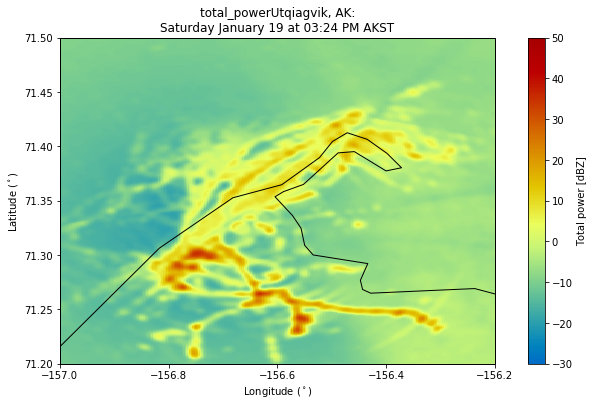

In [27]:
#Plot just the total power gridded data

field = 'total_power'

#projection = ccrs.PlateCarree(central_longitude=rlon, min_latitude=rlat-5., max_latitude=rlat+5.)


fig = plt.figure(figsize = (12, 6))

my_ax = plt.subplot(projection = ccrs.PlateCarree())

pc = ds.total_power[0].sel(z=10, method='nearest').plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    ax=my_ax,
    x='lon', y='lat',
    vmin=-30, vmax=50, 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

#Set lat an lon lines and aspect ratios
lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), ds.lat.max(), .05)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1), ds.lon.max(), .2)
my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())

land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')

# Make it not stretchy
my_ax.set_aspect(aspect = 2)

# Change labels
my_ax.set_xlabel("Longitude ($^\circ$)")
my_ax.set_ylabel("Latitude ($^\circ$)")
my_ax.set_title(field + "Utqiagvik, AK:" + "\n" + fancy_date_string)

# Crop all this
my_ax.set_xlim(-157.0, -156.2)
my_ax.set_ylim(71.2, 71.5)

#Add coastline
my_ax.add_feature(coastlines, linestyle='-', edgecolor='k', linewidth=1)

#my_ax.coastlines(resolution = '10m')
plt.show()
plt.close()


#my_ax.add_feature(coastline, linestyle = "-", edgecolor = "black")




Now generalize for all properties and make a gif for the whole Jan 20 evening timespan used earlier

In [ ]:
dir(plt)